### Cluster the response of cells

In [46]:
import glob
from pathlib import Path
import xarray as xr
from sklearn import decomposition, manifold, preprocessing, cluster
from scipy import interpolate
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy.interpolate import splrep, BSpline

In [2]:
path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22'

In [3]:
neuropixel_path = sorted(glob.glob(path+'/*/ephys/states.npy'))

In [5]:
# check output
for p in neuropixel_path:
    metrics_file = Path(p).parent.parent/'processed'/'cell_metrics_full.nc'
    if not metrics_file.exists():
        print(p)

/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-14-165110/ephys/states.npy
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/states.npy
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-04-11-195450/ephys/states.npy


### Load files

In [7]:
path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22'
files = list(Path(path).glob('*/processed/xr_spikes_trials.nc'))

In [8]:
data_list = []
df_cell_prop = []
for i in tqdm(range(2)):
    dataset = xr.open_dataset(files[i])
    da = dataset['spikes_zFR.first_spout']
    # da = da.mean(dim='trial_nb') #need to speed up the merge
    data_list.append(da)

    df = pd.read_pickle(files[i].parent/'df_cell_prop.pkl')
    df_cell_prop.append(df)
cell_da = xr.merge(data_list)
df_cell_prop = pd.concat(df_cell_prop)

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
cell_da

<xarray.Dataset>
Dimensions:                 (cluID: 1478, trial_nb: 212, spk_event_time: 251)
Coordinates:
  * cluID                   (cluID) object 'TT001-2023-06-21-142149_ProbeA_0'...
  * trial_nb                (trial_nb) float64 1.0 2.0 3.0 ... 210.0 211.0 212.0
  * spk_event_time          (spk_event_time) float64 -500.0 -490.0 ... 2e+03
Data variables:
    spikes_zFR.first_spout  (trial_nb, spk_event_time, cluID) float64 -0.0231...

In [10]:
# only include significant cells
max_region_size = df_cell_prop['spikes_FR.first_spout:max_region_size']
df_sel = df_cell_prop[(max_region_size>10) & (max_region_size<100)]
df_sel

,spikes_FR.trial_onset:pvalues,spikes_FR.trial_onset:pvalue_ratio,spikes_FR.trial_onset:max_region_size,spikes_FR.first_bar_off:pvalues,spikes_FR.first_bar_off:pvalue_ratio,spikes_FR.first_bar_off:max_region_size,spikes_FR.last_bar_off:pvalues,spikes_FR.last_bar_off:pvalue_ratio,spikes_FR.last_bar_off:max_region_size,spikes_FR.first_spout:pvalues,...,spikes_FR.reward:pvalues,spikes_FR.reward:pvalue_ratio,spikes_FR.reward:max_region_size,spikes_FR.pre-cue1000:pvalues,spikes_FR.pre-cue1000:pvalue_ratio,spikes_FR.pre-cue1000:max_region_size,cluID,pos_x,pos_y,maxWaveformCh
1,"[0.1782178217821782, 0.25742574257425743, 0.37...",0.075697,0.0,"[0.5742574257425742, 0.8316831683168316, 0.910...",0.290837,15.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.685259,82.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.8712871287128713, 0.6534653465346535, 0.316...",0.494024,33.0,"[0.3564356435643564, 0.2376237623762376, 0.138...",0.127490,0.0,kms058-2023-03-24-151254_ProbeA_101,48,480,49.0
2,"[0.9900990099009901, 0.8910891089108911, 0.653...",0.095618,0.0,"[0.6732673267326733, 0.9306930693069307, 0.990...",0.135458,11.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.402390,33.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.09900990099009901, 0.15841584158415842, 0.1...",0.219124,13.0,"[0.07920792079207921, 0.0594059405940594, 0.13...",0.079681,0.0,kms058-2023-03-24-151254_ProbeA_107,32,500,51.0
9,"[0.5742574257425742, 0.4158415841584158, 0.257...",0.386454,30.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.649402,0.0,"[0.019801980198019802, 0.039603960396039604, 0...",0.470120,99.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.195219,29.0,"[0.0594059405940594, 0.0594059405940594, 0.039...",0.298805,16.0,kms058-2023-03-24-151254_ProbeA_115,48,560,57.0
11,"[0.0594059405940594, 0.0594059405940594, 0.079...",0.091633,0.0,"[0.49504950495049505, 0.3564356435643564, 0.21...",0.231076,15.0,"[0.31683168316831684, 0.31683168316831684, 0.3...",0.258964,60.0,"[0.49504950495049505, 0.7128712871287128, 0.97...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.127490,29.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.151394,12.0,kms058-2023-03-24-151254_ProbeA_117,16,560,56.0
13,"[0.37623762376237624, 0.33663366336633666, 0.4...",0.334661,13.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.350598,44.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.876494,66.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.856574,84.0,"[0.15841584158415842, 0.09900990099009901, 0.0...",0.462151,28.0,kms058-2023-03-24-151254_ProbeA_12,32,100,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,"[0.1188118811881188, 0.07920792079207921, 0.07...",0.063745,0.0,"[0.7326732673267327, 0.9504950495049505, 0.554...",0.119522,0.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.752988,28.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.649402,26.0,"[0.297029702970297, 0.39603960396039606, 0.415...",0.007968,0.0,TT001-2023-06-21-142149_ProbeB_90,0,460,46.0
782,"[0.297029702970297, 0.15841584158415842, 0.118...",0.067729,0.0,"[0.693069306930693, 0.5742574257425742, 0.5940...",0.043825,0.0,"[0.039603960396039604, 0.039603960396039604, 0...",0.418327,23.0,"[0.039603960396039604, 0.039603960396039604, 0...",...,"[0.15841584158415842, 0.21782178217821782, 0.3...",0.366534,33.0,"[1.0, 0.9504950495049505, 0.8910891089108911, ...",0.035857,0.0,TT001-2023-06-21-142149_ProbeB_916,48,3720,373.0
787,"[0.4752475247524752, 0.27722772277227725, 0.27...",0.051793,0.0,"[0.7326732673267327, 1.0, 0.8712871287128713, ...",0.031873,0.0,"[0.21782178217821782, 0.15841584158415842, 0.0...",0.545817,28.0,"[0.039603960396039604, 0.039603960396039604, 0...",...,"[0.039603960396039604, 0.03960396039

In [11]:
da = cell_da['spikes_zFR.first_spout'].sel(cluID=df_sel.cluID.values)

In [20]:
data = da.isel(cluID=3).data

In [51]:
data.shape
x = np.tile(da.spk_event_time,(data.shape[0],1)).ravel()
y = data.ravel()

idx = ~np.isnan(y)
y = y[idx]
x = x[idx]

# sort_idx = np.argsort(x)
# x = x[sort_idx]
# y = y[sort_idx]

tck  = interpolate.CubicSpline(x,y)

ValueError: `x` must be strictly increasing sequence.

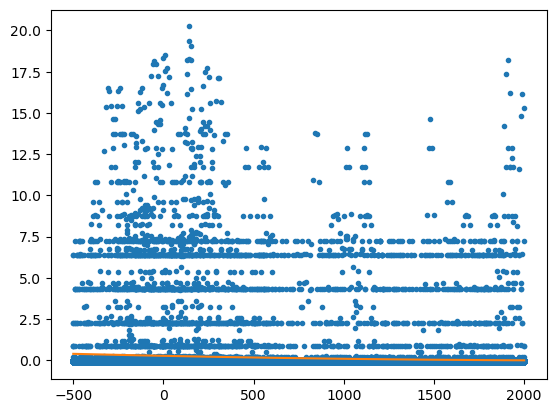

In [57]:
z = np.polyfit(x,y,2)
p = np.poly1d(z)
y_ = p(da.spk_event_time)
plt.plot(x,y,'.')
plt.plot(da.spk_event_time, y_)
